In [1]:
# general tools
import os
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from keras_unet_collection import utils as k_utils

2022-12-28 12:07:01.193596: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

In [4]:
import re

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def pos_mixer(TRAIN, L, a0=0, a1=0.2):
    data_shape = TRAIN.shape
    out = np.empty((L, data_shape[-1]))
    
    for i in range(L):
        inds = np.random.choice(data_shape[0], 2)
        a = np.random.uniform(a0, a1)
        out[i, :] = a*TRAIN[inds[0], :] + (1-a)*TRAIN[inds[1], :]
    return out

In [7]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [8]:
def verif_metric(VALID_target, Y_pred, ref):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    #print('{}'.format(BS))
    metric = BS

    return metric / ref

In [9]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [10]:
def feature_extract(filenames, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max):
    
    lon_out = []
    lat_out = []
    elev_out = []
    mon_out = []
    
    base_v3_s = datetime(2018, 7, 15)
    base_v3_e = datetime(2020, 12, 2)

    base_v4_s = datetime(2020, 12, 3)
    base_v4_e = datetime(2022, 7, 15)

    base_ref = datetime(2010, 1, 1)
    
    date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
    date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180-151)]
    
    for i, name in enumerate(filenames):
        
        if 'v4' in name:
            date_list = date_list_v4
        else:
            date_list = date_list_v3
        
        nums = re.findall(r'\d+', name)
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
        day = date_list[day]
        month = day.month
        
        month_norm = (month - 1)/(12-1)
        
        lon = lon_80km[indx, indy]
        lat = lat_80km[indx, indy]

        lon = (lon - lon_minmax[0])/(lon_minmax[1] - lon_minmax[0])
        lat = (lat - lat_minmax[0])/(lat_minmax[1] - lat_minmax[0])

        elev = elev_80km[indx, indy]
        elev = elev / elev_max
        
        lon_out.append(lon)
        lat_out.append(lat)
        elev_out.append(elev)
        mon_out.append(month_norm)
        
    return np.array(lon_out), np.array(lat_out), np.array(elev_out), np.array(mon_out)

def create_model():

    
    IN_vec = keras.Input((123,))    
    X = IN_vec
    #
    X = keras.layers.Dense(1024, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)

    X = keras.layers.Dropout(0.4)(X)
    
    #
    X = keras.layers.Dense(512, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)
    
    X = keras.layers.Dropout(0.4)(X)
    
    X = keras.layers.Dense(128, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)
    
    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=IN_vec, outputs=OUT)
    
    return model

In [11]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    elev_3km = h5io['elev_3km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    
grid_shape = land_mask_80km.shape

In [12]:
elev_80km = du.interp2d_wraper(lon_3km, lat_3km, elev_3km, lon_80km, lat_80km, method='linear')

elev_80km[np.isnan(elev_80km)] = 0
elev_80km[elev_80km<0] = 0
elev_max = np.max(elev_80km)

lon_80km_mask = lon_80km[land_mask_80km]
lat_80km_mask = lat_80km[land_mask_80km]

lon_minmax = [np.min(lon_80km_mask), np.max(lon_80km_mask)]
lat_minmax = [np.min(lat_80km_mask), np.max(lat_80km_mask)]

In [13]:
lead = 21

In [14]:
filename_train_lead19 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*lead19.npy"))
filename_train_lead20 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*lead20.npy"))
filename_train_lead21 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*lead21.npy"))
filename_train_lead22 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*lead22.npy"))

In [15]:
IND_TRAIN_lead = np.load('/glade/work/ksha/NCAR/IND_TRAIN_lead.npy', allow_pickle=True)[()]
TRAIN_ind19 = IND_TRAIN_lead['lead19']
TRAIN_ind20 = IND_TRAIN_lead['lead20']
TRAIN_ind21 = IND_TRAIN_lead['lead21']
TRAIN_ind22 = IND_TRAIN_lead['lead22']

In [16]:
filepath_vec = "/glade/work/ksha/NCAR/"

In [17]:
data_lead19_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_base.npy'.format(filepath_vec, 19), allow_pickle=True)[()]
data_lead19_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_base.npy'.format(filepath_vec, 19), allow_pickle=True)[()]
data_lead19_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_base.npy'.format(filepath_vec, 19), allow_pickle=True)[()]

data_lead20_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_base.npy'.format(filepath_vec, 20), allow_pickle=True)[()]
data_lead20_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_base.npy'.format(filepath_vec, 20), allow_pickle=True)[()]
data_lead20_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_base.npy'.format(filepath_vec, 20), allow_pickle=True)[()]

data_lead21_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_base.npy'.format(filepath_vec, 21), allow_pickle=True)[()]
data_lead21_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_base.npy'.format(filepath_vec, 21), allow_pickle=True)[()]
data_lead21_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_base.npy'.format(filepath_vec, 21), allow_pickle=True)[()]

data_lead22_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_base.npy'.format(filepath_vec, 22), allow_pickle=True)[()]
data_lead22_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_base.npy'.format(filepath_vec, 22), allow_pickle=True)[()]
data_lead22_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_base.npy'.format(filepath_vec, 22), allow_pickle=True)[()]

In [18]:
TRAIN_lead19 = np.concatenate((data_lead19_p0['y_vector'], 
                               data_lead19_p1['y_vector'], 
                               data_lead19_p2['y_vector']), axis=0)

TRAIN_lead20 = np.concatenate((data_lead20_p0['y_vector'], 
                               data_lead20_p1['y_vector'], 
                               data_lead20_p2['y_vector']), axis=0)

TRAIN_lead21 = np.concatenate((data_lead21_p0['y_vector'], 
                               data_lead21_p1['y_vector'], 
                               data_lead21_p2['y_vector']), axis=0)

TRAIN_lead22 = np.concatenate((data_lead22_p0['y_vector'], 
                               data_lead22_p1['y_vector'], 
                               data_lead22_p2['y_vector']), axis=0)

In [19]:
TRAIN_lead19_y = np.concatenate((data_lead19_p0['y_true'], 
                                 data_lead19_p1['y_true'], 
                                 data_lead19_p2['y_true']), axis=0)

TRAIN_lead20_y = np.concatenate((data_lead20_p0['y_true'], 
                                 data_lead20_p1['y_true'], 
                                 data_lead20_p2['y_true']), axis=0)

TRAIN_lead21_y = np.concatenate((data_lead21_p0['y_true'], 
                                 data_lead21_p1['y_true'], 
                                 data_lead21_p2['y_true']), axis=0)

TRAIN_lead22_y = np.concatenate((data_lead22_p0['y_true'], 
                                 data_lead22_p1['y_true'], 
                                 data_lead22_p2['y_true']), axis=0)

In [20]:
L = len(TRAIN_ind21)

filename_train19_pick = []
filename_train20_pick = []
filename_train21_pick = []
filename_train22_pick = []

TRAIN_X = np.empty((L, 512))
TRAIN_Y = np.empty(L)

for i in range(L):
    
    ind_lead19 = int(TRAIN_ind19[i])
    ind_lead20 = int(TRAIN_ind20[i])
    ind_lead21 = int(TRAIN_ind21[i])
    ind_lead22 = int(TRAIN_ind22[i])
    
    filename_train19_pick.append(filename_train_lead19[ind_lead19])
    filename_train20_pick.append(filename_train_lead20[ind_lead20])
    filename_train21_pick.append(filename_train_lead21[ind_lead21])
    filename_train22_pick.append(filename_train_lead22[ind_lead22])
    
    TRAIN_X[i, 0:128]   = TRAIN_lead19[ind_lead19, :]
    TRAIN_X[i, 128:256] = TRAIN_lead20[ind_lead20, :]
    TRAIN_X[i, 256:384] = TRAIN_lead21[ind_lead21, :]
    TRAIN_X[i, 384:512] = TRAIN_lead22[ind_lead22, :]
    
    TRAIN_Y[i] = TRAIN_lead21_y[ind_lead21]

In [21]:
lon_norm, lat_norm, elev_norm, mon_norm = feature_extract(
    filename_train21_pick, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max)

In [22]:
data_temp = np.load('/glade/work/ksha/NCAR/TRAIN_MINMAX_lead{}.npy'.format(19), allow_pickle=True)[()]
MEAN_lead19 = data_temp['MEAN']
MAX_lead19 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/TRAIN_MINMAX_lead{}.npy'.format(20), allow_pickle=True)[()]
MEAN_lead20 = data_temp['MEAN']
MAX_lead20 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/TRAIN_MINMAX_lead{}.npy'.format(21), allow_pickle=True)[()]
MEAN_lead21 = data_temp['MEAN']
MAX_lead21 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/TRAIN_MINMAX_lead{}.npy'.format(22), allow_pickle=True)[()]
MEAN_lead22 = data_temp['MEAN']
MAX_lead22 = data_temp['MAX']

In [23]:
TRAIN_stn = np.concatenate((lon_norm[:, None], lat_norm[:, None], elev_norm[:, None], 
                            MAX_lead19, MAX_lead20, MAX_lead21, MAX_lead22, 
                            MEAN_lead19, MEAN_lead20, MEAN_lead21, MEAN_lead22), axis=1)
TRAIN_merge = TRAIN_stn

In [24]:
TRAIN_256_pos = TRAIN_X[TRAIN_Y==1, :]
TRAIN_256_neg = TRAIN_X[TRAIN_Y==0, :]

In [25]:
TRAIN_stn_pos = TRAIN_merge[TRAIN_Y==1]
TRAIN_stn_neg = TRAIN_merge[TRAIN_Y==0]

**Valid**

In [26]:
filename_valid_lead19 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*lead19.npy"))
filename_valid_lead20 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*lead20.npy"))
filename_valid_lead21 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*lead21.npy"))
filename_valid_lead22 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*lead22.npy"))

In [27]:
valid_lead19 = np.load('{}TEST_pp15_pred_lead19_base.npy'.format(filepath_vec), allow_pickle=True)[()]
valid_lead20 = np.load('{}TEST_pp15_pred_lead20_base.npy'.format(filepath_vec), allow_pickle=True)[()]
valid_lead21 = np.load('{}TEST_pp15_pred_lead21_base.npy'.format(filepath_vec), allow_pickle=True)[()]
valid_lead22 = np.load('{}TEST_pp15_pred_lead22_base.npy'.format(filepath_vec), allow_pickle=True)[()]

VALID_lead19 = valid_lead19['y_vector']
VALID_lead20 = valid_lead20['y_vector']
VALID_lead21 = valid_lead21['y_vector']
VALID_lead22 = valid_lead22['y_vector']

VALID_lead19_y = valid_lead19['y_true']
VALID_lead20_y = valid_lead20['y_true']
VALID_lead21_y = valid_lead21['y_true']
VALID_lead22_y = valid_lead22['y_true']

In [28]:
data_p_valid = np.load('{}TEST_pp15_pred_lead{}_base.npy'.format(filepath_vec, lead), allow_pickle=True)[()]

VALID_256 = data_p_valid['y_vector']
VALID_pred = data_p_valid['y_pred']
VALID_Y = data_p_valid['y_true']

In [29]:
IND_VALID_lead = np.load('/glade/work/ksha/NCAR/IND_VALID_lead.npy', allow_pickle=True)[()]

VALID_ind19 = IND_VALID_lead['lead19']
VALID_ind20 = IND_VALID_lead['lead20']
VALID_ind21 = IND_VALID_lead['lead21']
VALID_ind22 = IND_VALID_lead['lead22']

In [30]:
L = len(VALID_ind21)

filename_valid19_pick = []
filename_valid20_pick = []
filename_valid21_pick = []
filename_valid22_pick = []

VALID_X = np.empty((L, 512))
VALID_Y = np.zeros(L)

for i in range(L):
    
    ind_lead19 = int(VALID_ind19[i])
    ind_lead20 = int(VALID_ind20[i])
    ind_lead21 = int(VALID_ind21[i])
    ind_lead22 = int(VALID_ind22[i])
    
    filename_valid19_pick.append(filename_valid_lead19[ind_lead19])
    filename_valid20_pick.append(filename_valid_lead20[ind_lead20])
    filename_valid21_pick.append(filename_valid_lead21[ind_lead21])
    filename_valid22_pick.append(filename_valid_lead22[ind_lead22])
    
    VALID_X[i, 0:128]   = VALID_lead19[ind_lead19, :]
    VALID_X[i, 128:256] = VALID_lead20[ind_lead20, :]
    VALID_X[i, 256:384] = VALID_lead21[ind_lead21, :]
    VALID_X[i, 384:512] = VALID_lead22[ind_lead22, :]
    
    if 'pos' in filename_valid_lead21[ind_lead21]:
        if VALID_lead21_y[ind_lead21] == 1.0:
            VALID_Y[i] = 1.0
        else:
            egwrshat

In [31]:
lon_norm, lat_norm, elev_norm, mon_norm = feature_extract(
    filename_valid21_pick, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max)

In [32]:
data_temp = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead{}.npy'.format(19), allow_pickle=True)[()]
MEAN_lead19 = data_temp['MEAN']
MAX_lead19 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead{}.npy'.format(20), allow_pickle=True)[()]
MEAN_lead20 = data_temp['MEAN']
MAX_lead20 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead{}.npy'.format(21), allow_pickle=True)[()]
MEAN_lead21 = data_temp['MEAN']
MAX_lead21 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead{}.npy'.format(22), allow_pickle=True)[()]
MEAN_lead22 = data_temp['MEAN']
MAX_lead22 = data_temp['MAX']

In [33]:
VALID_stn = np.concatenate((lon_norm[:, None], lat_norm[:, None], elev_norm[:, None], 
                            MAX_lead19, MAX_lead20, MAX_lead21, MAX_lead22, 
                            MEAN_lead19, MEAN_lead20, MEAN_lead21, MEAN_lead22), axis=1)
VALID_merge = VALID_stn

In [34]:
VALID_merge.shape

(278588, 123)

In [35]:
training_rounds = 20
seeds = [12342, 2536234, 98765, 473, 865, 7456, 69472, 3456357, 3425, 678,
         2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695]

In [36]:
ref = np.sum(VALID_Y) / len(VALID_Y)

# =========== Model Section ========== #

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'STN_Lead{}'.format(lead)

model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(TRAIN_256_pos)
L_neg = len(TRAIN_256_neg)

record = 1.1 #0.8545884976606543 #0.860262977437387 #0.867447696352988 #1.1
print("Initial record: {}".format(record))

min_del = 0
max_tol = 100 # early stopping with patience

epochs = 500
batch_size = 64
L_train = 16 #int(len(TRAIN_Y_pick) / batch_size)

for r in range(training_rounds):
    if r == 0:
        tol = 0
    else:
        tol = -200

    model = create_model()
    #
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(lr=1e-4))
    
    # W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/BASE_Lead2/')
    # model.set_weights(W_old)
    
    set_seeds(int(seeds[r]))
    print('Training round {}'.format(r))

    for i in range(epochs):
        # if i > 0:
        #     backend.set_value(model.optimizer.learning_rate, decayed_learning_rate(i))
            
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            N_pos = 32
            N_neg = batch_size - N_pos

            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)

            ind_neg_pick = ind_neg[:N_neg]
            ind_pos_pick = ind_pos[:N_pos]

            X_batch_neg = TRAIN_stn_neg[ind_neg_pick, :]
            X_batch_pos = TRAIN_stn_pos[ind_pos_pick, :]

            X_batch = np.concatenate((X_batch_neg, X_batch_pos), axis=0)

            Y_batch = np.ones([batch_size,])
            Y_batch[:N_neg] = 0.0

            ind_ = du.shuffle_ind(batch_size)

            X_batch = X_batch[ind_, :]
            Y_batch = Y_batch[ind_]

            # train on batch
            model.train_on_batch(X_batch, Y_batch);

        # epoch end operations
        Y_pred = model.predict(VALID_merge)

        Y_pred[Y_pred<0] = 0
        Y_pred[Y_pred>1] = 1

        record_temp = verif_metric(VALID_Y, Y_pred, ref)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del):
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp > 1.0:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 1.1


2022-12-28 12:08:59.917738: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-28 12:09:00.304659: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-28 12:09:00.370317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-12-28 12:09:00.370365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-28 12:09:00.575776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-28 12:09:00.575846: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Training round 0


2022-12-28 12:09:10.994428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-28 12:09:11.023093: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-12-28 12:09:11.347675: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Validation loss improved from 1.1 to 0.9997517149339793
save to: /glade/work/ksha/NCAR/Keras_models/STN_Lead21


2022-12-28 12:09:17.850964: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/STN_Lead21/assets
--- 11.697668313980103 seconds ---
Validation loss improved from 0.9997517149339793 to 0.9996228875697383
save to: /glade/work/ksha/NCAR/Keras_models/STN_Lead21
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/STN_Lead21/assets
--- 6.5339438915252686 seconds ---
Validation loss improved from 0.9996228875697383 to 0.9995940560894242
save to: /glade/work/ksha/NCAR/Keras_models/STN_Lead21
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/STN_Lead21/assets
--- 5.8524391651153564 seconds ---
Validation loss improved from 0.9995940560894242 to 0.9995841455623559
save to: /glade/work/ksha/NCAR/Keras_models/STN_Lead21
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/STN_Lead21/assets
--- 6.407821178436279 seconds ---
Validation loss improved from 0.9995841455623559 to 0.9995027178355814
save to: /glade/work/ksha/NCAR/Keras_models/STN_Lead21
INFO:

In [ ]:
temp_data = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead2.npy')[()]

In [ ]:
temp_data['MAX'].shape

In [45]:
model = create_model()

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(lr=0))

W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/STN_Lead4/')
model.set_weights(W_old)

In [46]:
ref = np.sum(VALID_Y) / len(VALID_Y)
Y_pred = model.predict(VALID_merge)
record_temp = verif_metric(VALID_Y, Y_pred, ref)

In [47]:
record_temp

0.8759321340156129

In [48]:
record_temp

0.8759321340156129

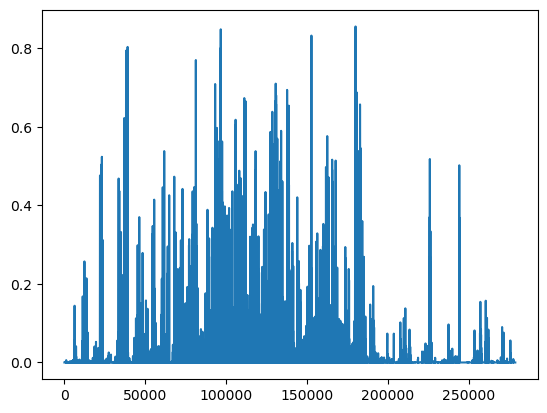

In [49]:
plt.plot(Y_pred)

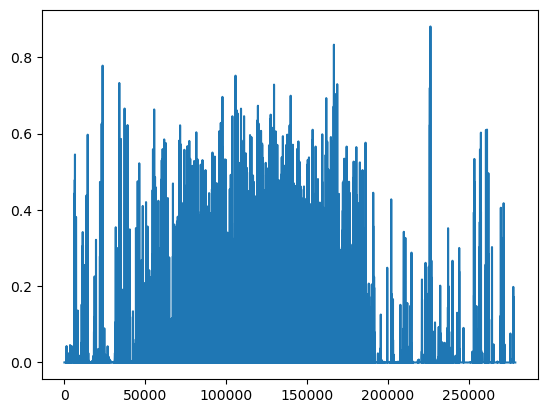

In [51]:
plt.plot(Y_pred)